In [53]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from map_fusion_network import MapFusion
from datasets.steel_dataset import SeverstalDataset
from models.clipseg import CLIPDensePredT
import matplotlib.pyplot as plt
from skimage import measure

In [54]:
def denormalize_batch(tensor, mean, std):
    """
    Reverses normalization for a batch of images.
    Input:  tensor of shape [B, 3, H, W]
    Output: denormalized tensor of same shape
    """
    mean = torch.tensor(mean).reshape(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).reshape(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean


def plot_with_mask_contour(image_tensor, mask_tensor, mean, std, idx=0):
    """
    Visualizes a single query image with ground truth mask contour overlay.
    image_tensor: [B, 3, H, W]
    mask_tensor:  [B, H, W] or [B, 1, H, W]
    idx: which sample in the batch to visualize
    """
    # Prepare the image
    image = denormalize_batch(image_tensor, mean, std)[idx].cpu()
    image = torch.clamp(image, 0, 1).permute(1, 2, 0).numpy()  # [H, W, 3]

    # Prepare the mask
    mask = mask_tensor[idx]
    if mask.ndim == 3:  # [1, H, W]
        mask = mask.squeeze(0)
    mask = mask.cpu().numpy()

    # Find contours
    contours = measure.find_contours(mask, level=0.5)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    plt.title("Image with Ground Truth Contour")
    plt.axis('off')
    plt.show()

In [55]:
torch.cuda.empty_cache()

In [56]:
import torch

weights_path = '../weights/severstal_text_only/fusion_model_epoch_33.pth'
batch_size = 16
json_path = '../Severstal/annotations_COCO.json'
image_dir = '../Severstal/train_subimages'
n_support = 2
mean = [0.34388125, 0.34388125, 0.34388125]
std = [0.13965334, 0.13965334, 0.13965334]
image_size = 256

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
num_classes = 5  # Change to match your model

dataset = SeverstalDataset(json_path=json_path, image_dir=image_dir, image_size=(256, 256),
                               n_support=n_support, transform=transform, split='val')
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=False)
clipseg_model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)

# ------------------------
# Load Model
# ------------------------
model = MapFusion(num_classes=num_classes, clipseg_model=clipseg_model).cuda()
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cuda')), strict=False)
model.eval()

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


/tmp/ipykernel_12643/695041740.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=torch.device('cuda')), strict

MapFusion(
  (clipseg_model): CLIPDensePredT(
    (clip_model): CLIP(
      (visual): VisionTransformer(
        (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
        (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (transformer): Transformer(
          (resblocks): Sequential(
            (0): ResidualAttentionBlock(
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
              )
              (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): Sequential(
                (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                (gelu): QuickGELU()
                (c_proj): Linear(in_features=3072, out_features=768, bias=True)
              )
              (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            )
            (1): ResidualAttentionBlock(
              

In [57]:
#RESULTS VISUALIZATION

batch = next(iter(data_loader))
    
query_image = batch['query_image'].cuda()
mask = batch['query_mask'].long().cuda()
support = batch['support']
result = model.forward(query_image, support)
preds = torch.argmax(result, dim=1)
    
query_image = denormalize_batch(query_image, mean, std) #Denormalize for better visualization 

In [58]:
# Ensure query_images are in [B, H, W, 3] format for plotting
"""
images = query_image.permute(0, 2, 3, 1).cpu().numpy()  # [B, H, W, C]
gt = mask.cpu().numpy()
pred = preds.cpu().numpy()

num_samples = 5
plt.figure(figsize=(num_samples * 2, 4))

for i in range(num_samples):
    # Query Image
    mask = gt[i]
    
    contours = measure.find_contours(mask, level=0.5)
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(images[i])
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    plt.title("Image")
    plt.axis('off')
    
    # Prediction
    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(pred[i], cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()
"""

'\nimages = query_image.permute(0, 2, 3, 1).cpu().numpy()  # [B, H, W, C]\ngt = mask.cpu().numpy()\npred = preds.cpu().numpy()\n\nnum_samples = 5\nplt.figure(figsize=(num_samples * 2, 4))\n\nfor i in range(num_samples):\n    # Query Image\n    mask = gt[i]\n    \n    contours = measure.find_contours(mask, level=0.5)\n    plt.subplot(2, num_samples, i + 1)\n    plt.imshow(images[i])\n    for contour in contours:\n        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color=\'red\')\n    plt.title("Image")\n    plt.axis(\'off\')\n    \n    # Prediction\n    plt.subplot(2, num_samples, i + 1 + num_samples)\n    plt.imshow(pred[i], cmap=\'gray\')\n    plt.title("Prediction")\n    plt.axis(\'off\')\n\nplt.tight_layout()\nplt.show()\n'

Unique classes in GT: [0 1 2 3 4]
Unique classes in predictions: [0 1 2 3 4]


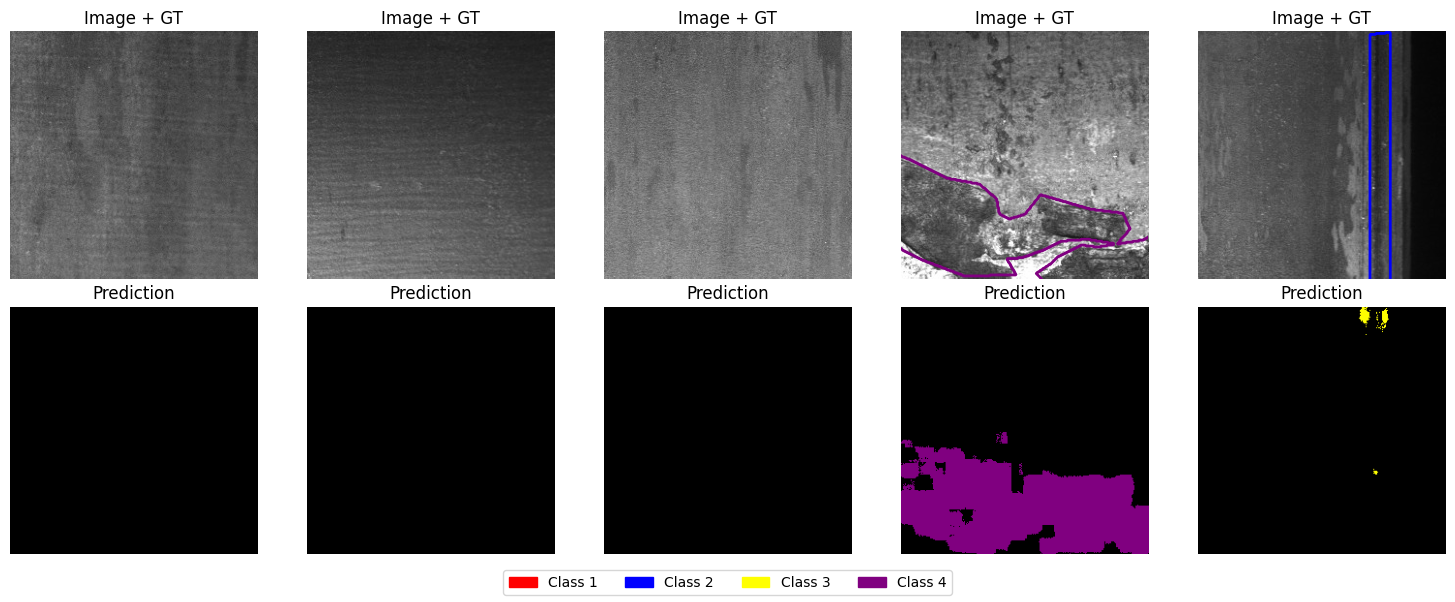

In [59]:
import matplotlib.pyplot as plt
from skimage import measure
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.colors import to_rgb

# Define class → color and name mapping (excluding background 0)
label_colors = {
    1: 'red',
    2: 'blue',
    3: 'yellow',
    4: 'purple'
}
label_names = {
    1: 'Class 1',
    2: 'Class 2',
    3: 'Class 3',
    4: 'Class 4'
}

# Prepare data
images = query_image.permute(0, 2, 3, 1).cpu().numpy()
gt = mask.squeeze(1).cpu().numpy() if mask.ndim == 4 else mask.cpu().numpy()
pred = preds.squeeze(1).cpu().numpy() if preds.ndim == 4 else preds.cpu().numpy()

# Print unique classes for debugging
print("Unique classes in GT:", np.unique(gt))
print("Unique classes in predictions:", np.unique(pred))

# Create colormap array with default black for all classes present in predictions
num_classes = int(pred.max()) + 1  # covers all classes in prediction
cmap_array = np.zeros((num_classes, 3), dtype=np.float32)  # default black for all classes

# Assign known class colors
for k, color in label_colors.items():
    if k < num_classes:
        cmap_array[k] = to_rgb(color)

# Ensure background color (0) is black (or choose another color)
if 0 < num_classes:
    cmap_array[0] = np.array([0, 0, 0])

num_samples = 5
fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))
axes = axes.reshape(2, num_samples)

for i in range(num_samples):
    img = images[i]
    gt_mask = gt[i]
    pred_mask = pred[i]

    # --- Row 1: Image with GT contours ---
    ax1 = axes[0, i]
    ax1.imshow(img)
    for label in np.unique(gt_mask):
        if label == 0 or label not in label_colors:
            continue
        contours = measure.find_contours(gt_mask == label, level=0.5)
        for contour in contours:
            ax1.plot(contour[:, 1], contour[:, 0], linewidth=2, color=label_colors[label])
    ax1.set_title("Image + GT")
    ax1.axis('off')

    # --- Row 2: Predicted full-color mask ---
    ax2 = axes[1, i]
    # Safely map prediction classes to colors, clipping values above max color index
    safe_pred_mask = np.clip(pred_mask, 0, num_classes - 1)
    pred_rgb = cmap_array[safe_pred_mask]  # shape [H, W, 3]
    ax2.imshow(pred_rgb)
    ax2.set_title("Prediction")
    ax2.axis('off')

# Legend (excluding background)
handles = [mpatches.Patch(color=label_colors[k], label=label_names[k]) for k in label_colors]
fig.legend(handles=handles, loc='lower center', ncol=len(handles), fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for legend
plt.show()

